In [1]:
import torch.utils.data as data
from torch.utils.data import DataLoader
import os
import glob
import torch
import pathlib
from torchvision import transforms
from matplotlib import pyplot as plt
from pathlib import Path
import PIL.Image

# modified from https://discuss.pytorch.org/t/loading-ade20k-dataset/48684/2
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'images','training','0Probe','*.jpg'))
        self.mask_files = []
        for img_path in self.img_files:
             # we use `pathlib.Path(img_path).stem` to extract only the file name
             self.mask_files.append(os.path.join(folder_path,'annotations','training','0Probe',pathlib.Path(img_path).stem + ".png")) 

        # apparently this is necessary     
        self.transforms = transforms.Compose(
            [
                transforms.Resize(size=(320,320)),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.to(torch.float32)),
            ]
        )

    def __getitem__(self, index, observe=False):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = PIL.Image.open(img_path)
            label = PIL.Image.open(mask_path)
            if observe is True:
                # Displaying images (optional for debugging)
                print(f'original size of images:',data.size, label.size)  # Check image dimensions
                plt.figure(figsize=(10,5))
                plt.subplot(1,2,1)
                plt.imshow(data)
                
                plt.subplot(1,2,2)
                plt.imshow(label)
                plt.tight_layout()
                plt.show()
            return self.transforms(data), self.transforms(label)

    def __len__(self):
        return len(self.img_files)


File exists: True
original size of images: (683, 512) (683, 512)


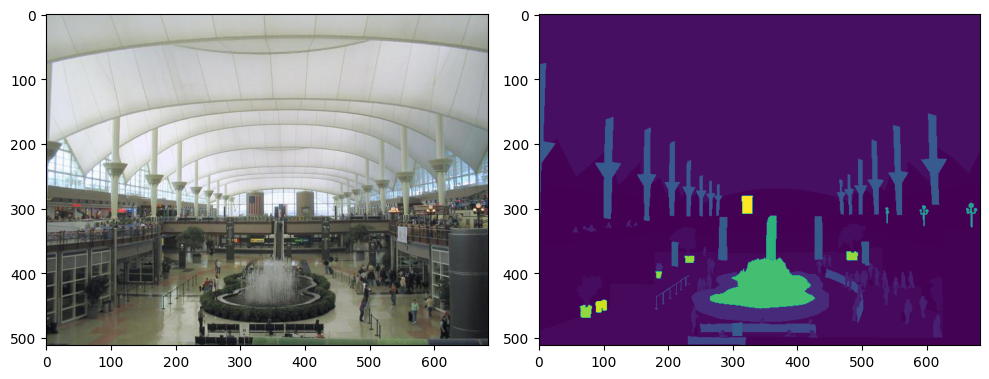

size after passing through __getitem__: torch.Size([3, 320, 320]) torch.Size([1, 320, 320])


In [2]:
folder_path = Path('./data/mseg_dataset/ADEChallengeData2016')
print(f"File exists: {folder_path.exists()}")
loader = DataLoaderSegmentation(folder_path=folder_path)

data_loader = DataLoader(loader,num_workers=4, batch_size=2, shuffle=False, pin_memory=True)

image_loader, label_loader = loader.__getitem__(0,observe=True)

print('size after passing through __getitem__:',image_loader.shape,label_loader.shape)

In [3]:
total_size = len(loader)
print(f"Total size of the dataset: {total_size}")


Total size of the dataset: 1


In [4]:
# define my dense prediction transformer (DPT) class
import lightning as L
import torch.nn as nn
import torch
import sys
sys.path.append(os.path.join(os.getcwd(), "DPT"))  
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from DPT import DPT


class LightningModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = DPT()
        self.max_epochs = 100
        self.loss_fn = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, idx):
        images, annotations = batch 
        annotations = annotations.squeeze(1).long()  # Convert to (B, W, H)
        predictions = self.model(images) # these are raw logits 
        #predictions = torch.softmax(predictions,dim=1)
        loss = self.loss_fn(predictions,annotations)
        # Logging to TensorBoard by default
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # paper: with momentum 0.9 and a polynomial learning rate scheduler with decay factor 0.9
        optimizer = torch.optim.SGD(self.parameters(), lr=0.002, momentum=0.9,weight_decay=1e-4)
        
        # Scheduler taken from https://github.com/rzhao5659/2024-LSeg/blob/main/test/test_dpt.ipynb
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
            optimizer, lambda epoch: pow(1.0 - epoch / self.max_epochs, 0.9)
        )
        return [optimizer], [lr_scheduler]

# this part was taken from https://github.com/rzhao5659/2024-LSeg/blob/main/test/test_dpt.ipynb
checkpoint_callback = ModelCheckpoint(
    monitor="train_loss",  # Metric to monitor
    mode="min",  # Save the model with the minimum training loss
    save_top_k=1,  # Only keep the best model
    filename="epoch={epoch}-train_loss={train_loss:.4f}",  # Filename format
    verbose=False,
)

my_dpt = LightningModel()

trainer = pl.Trainer(max_epochs=100, accelerator="gpu", devices=1, log_every_n_steps=1, callbacks=[checkpoint_callback])
trainer.fit(model=my_dpt, train_dataloaders=data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/rotakagui/miniconda3/envs/CLIP/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA RTX A5500') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_flo

Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, v_num=10]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined